In [43]:
import numpy as np
import uproot as ur
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd

from scipy import stats
from numba import njit

## Loading the data and obtaining a sort of profile histogram

- We first load the root file using uproot and show its contents

In [3]:
# Open the file and show its contents (like .ls in ROOT CERN)
t_hk_obox = ur.open("../data/Allaux_Bfield.root:t_hk_obox")
print(t_hk_obox.show())

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
odd_index            | int32_t                  | AsDtype('>i4')
even_index           | int32_t                  | AsDtype('>i4')
odd_is_bad           | int32_t                  | AsDtype('>i4')
even_is_bad          | int32_t                  | AsDtype('>i4')
obox_is_bad          | int32_t                  | AsDtype('>i4')
packet_num           | uint16_t                 | AsDtype('>u2')
timestamp            | uint32_t                 | AsDtype('>u4')
obox_mode            | uint8_t                  | AsDtype('uint8')
cpu_status           | uint16_t                 | AsDtype('>u2')
trig_status          | uint8_t                  | AsDtype('uint8')
comm_status          | uint8_t                  | AsDtype('uint8')
ct_temp              | float                    | AsDtype('>f4')
chain_temp           | float                    | As

- We can then obtain a dictionary where keys are some of the names shown above and values are numpy arrays containing the data. Note that we only keep a subset of the information

In [4]:
t_hk_obox_dict = t_hk_obox.arrays(["saa", 
                  "fe_temp",
                  "glon", 
                  "glat",
                  "tunix",
                  "fe_cosmic",
                  "fe_rate"], library="np")

- We are interested in the following curve which contains a background part and the gamma ray bursts we would like to detect:

In [5]:
tunix = t_hk_obox_dict["tunix"]
sum_fe_rate = np.sum(t_hk_obox_dict["fe_rate"], axis=1)

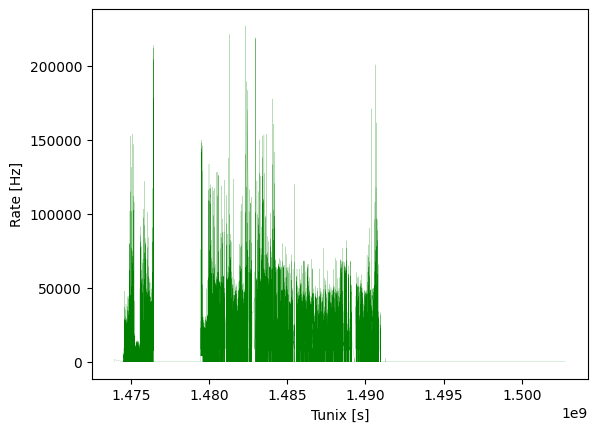

In [6]:
plt.plot(tunix, sum_fe_rate, 'g', linewidth=0.1)
plt.xlabel("Tunix [s]")
plt.ylabel("Rate [Hz]")  # TODO: nb. photons per second or nb. photons per 2 seconds
plt.show()

Therefore, we would like to predict the background part, subtract it from the curve and analyze or use the remaining part to detect gamma ray bursts (GRB).

As we can see from the previous plot, we see a large flat region on the right with no data. We can therefore crop the right part:

In [7]:
last_non_zero = sum_fe_rate.size-(np.flip(sum_fe_rate)>0).argmax() - 1
tunix = tunix[:last_non_zero+1]
sum_fe_rate = sum_fe_rate[:last_non_zero+1]

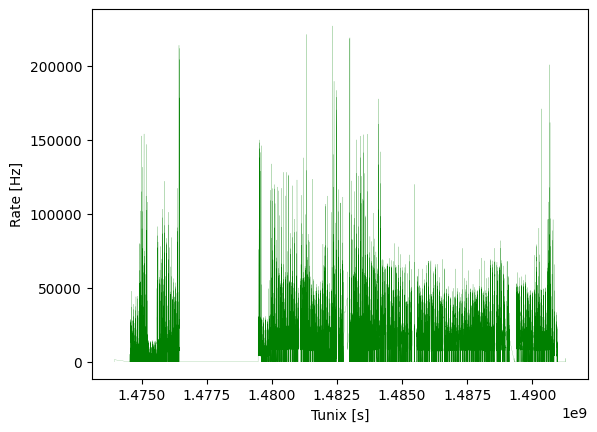

In [8]:
plt.plot(tunix, sum_fe_rate, 'g', linewidth=0.1)
plt.xlabel("Tunix [s]")
plt.ylabel("Rate [Hz]")  # TODO: nb. photons per second or nb. photons per 2 seconds
plt.show()

We can observe a lot of missing values due to the detector being switched off when astronauts went onboard the space station. Small missing values are due to the South Altantic Anomaly region.

- We can shift the time axis so that it starts at $0$. We can also bin the data

In [9]:
tunix_min = tunix.min()
tunix_shifted = tunix - tunix_min
bins = np.arange(0, tunix_shifted.max()+2, 2)

# Obtain indices of the bins in which the data falls.
# It will take the bin on the right, not the one of the left
indices_digitized = np.digitize(tunix_shifted, bins)
uniques_idx, counts_idx = np.unique(indices_digitized, return_counts=True)

In [10]:
pd.DataFrame(bins[uniques_idx].reshape(1, -1))

,0,1,2,3,4,5,6,7,8,9,...,6187613,6187614,6187615,6187616,6187617,6187618,6187619,6187620,6187621,6187622
0,2.0,4.0,6.0,10.0,12.0,18.0,20.0,26.0,28.0,34.0,...,17323018.0,17323020.0,17323022.0,17323024.0,17323026.0,17323028.0,17323030.0,17323032.0,17323034.0,17323036.0


We can observe that the bins start at $2$ seconds and this should be taken into account in the future.

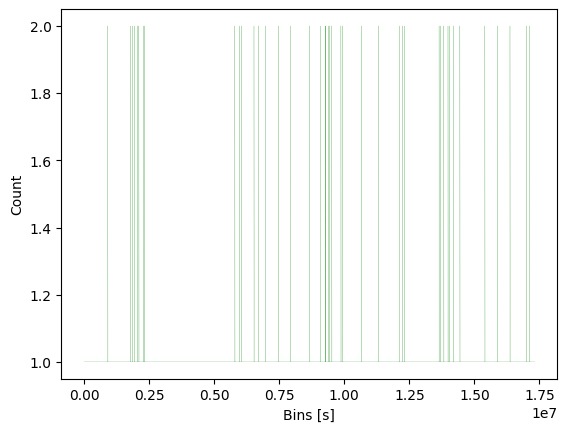

In [11]:
plt.plot(bins[uniques_idx], counts_idx, 'g', linewidth=0.1)
plt.xlabel("Bins [s]")
plt.ylabel("Count")  # nb. data falling into bin
plt.show()

- There are sometimes two data points in a bin, we can average the data falling into each bin (profile hist but without error bars).

In [12]:
# Quantized Shifted Time
t = bins[indices_digitized]

# First column is the quantized time, second is the 'average' rate within the bin
light_curve = np.array(pd.DataFrame(np.vstack([t, sum_fe_rate, indices_digitized]).T, 
                                    columns=["t", "sum_fe_rate", "idx"]).groupby("idx").mean())

In [13]:
t, y = light_curve.T

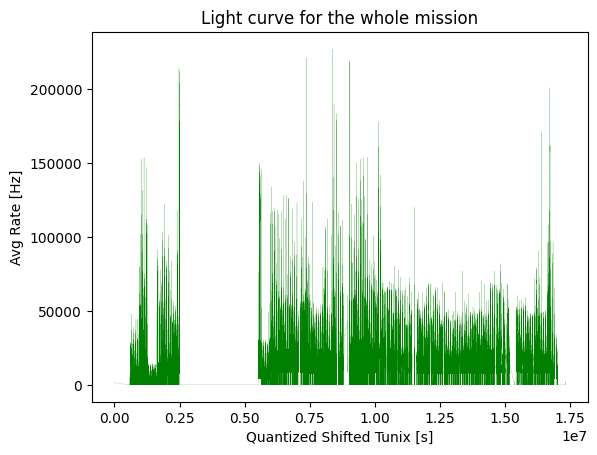

In [14]:
plt.plot(t, y, 'g', linewidth=0.1)
plt.xlabel("Quantized Shifted Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # TODO: verify : nb. photons per seconds (averaged over each bin) ?
plt.title("Light curve for the whole mission")
plt.show()

- Let's show just a small part of it (not the whole mission):

In [15]:
t.shape, y.shape

((6187623,), (6187623,))

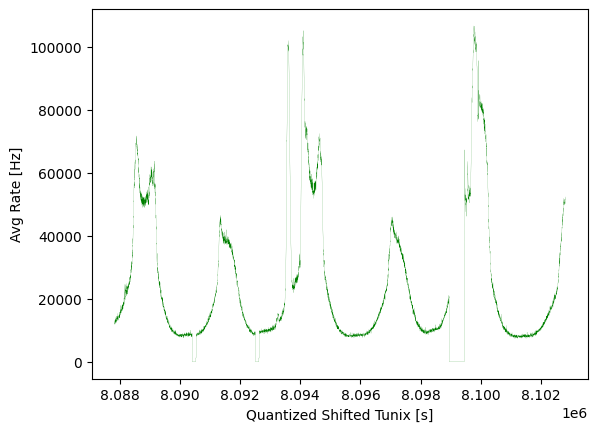

In [16]:
# Mask used to select a portion of the mission
mask = (t>(5000+1482032854-tunix_min)) & (t<(20000+1482032854-tunix_min))

plt.plot(t[mask], y[mask], '-g', linewidth=0.1)
plt.xlabel("Quantized Shifted Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # nb. photons per seconds (averaged over each bin)
plt.show()

---

## Fourier Transform

- Direct transform

In [17]:
fft_res = np.fft.fft(y)

- Frequency axis

In [18]:
freqs = np.fft.fftfreq(y.size, d=2)
pd.DataFrame(freqs.reshape(1, -1))

,0,1,2,3,4,5,6,7,8,9,...,6187613,6187614,6187615,6187616,6187617,6187618,6187619,6187620,6187621,6187622
0,0.0,8.080647e-08,1.616129e-07,2.424194e-07,3.232259e-07,4.040324e-07,4.848388e-07,5.656453e-07,6.464518e-07,7.272583e-07,...,-8.080647e-07,-7.272583e-07,-6.464518e-07,-5.656453e-07,-4.848388e-07,-4.040324e-07,-3.232259e-07,-2.424194e-07,-1.616129e-07,-8.080647e-08


In [19]:
print(f"freqs[:y.size//2+1].size={freqs[:y.size//2+1].size}, fft_res.size={fft_res.size}")

freqs[:y.size//2+1].size=3093812, fft_res.size=6187623


- Plotting the magnitude and the phase (without the first one)

In [20]:
mag = np.abs(fft_res)
phase = np.angle(fft_res)

# This below is used in the plots
mag_non_negative_freq = mag[:y.size//2+1]
phase_non_negative_freq = phase[:y.size//2+1]

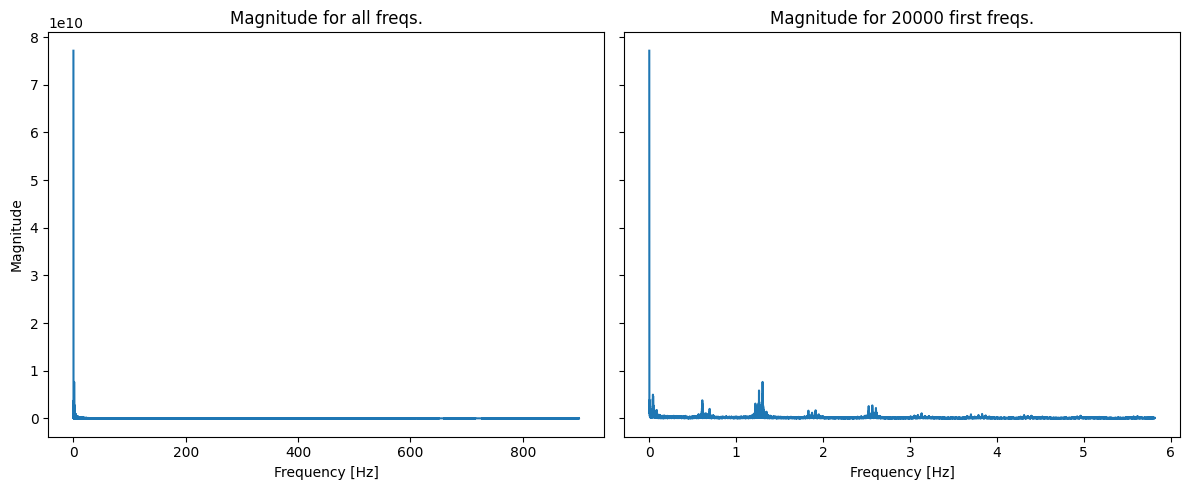

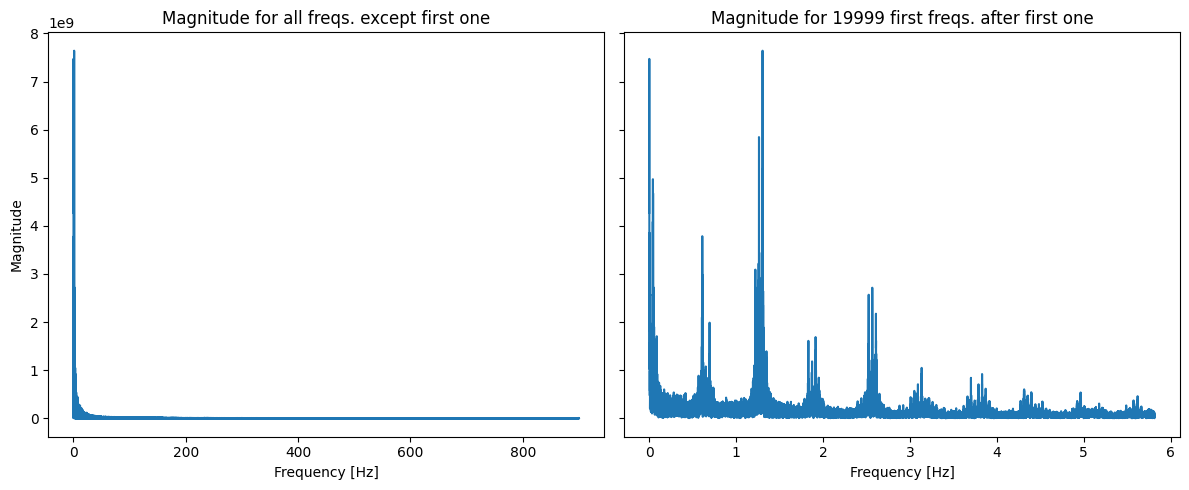

In [21]:
n = 20000  # number of frequencies to show

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].plot(3600*freqs[:y.size//2+1], mag_non_negative_freq[:])
axs[0].set_xlabel("Frequency [Hz]")   # TODO change units ... per hour
axs[0].set_ylabel("Magnitude")
axs[0].set_title("Magnitude for all freqs.")

axs[1].plot(3600*freqs[:y.size//2+1][:n], mag_non_negative_freq[:n])
axs[1].set_xlabel("Frequency [Hz]")  # TODO: fix the units ... per hour
axs[1].set_title(f"Magnitude for {n} first freqs.")
plt.tight_layout()
plt.show()


fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs2[0].plot(3600*freqs[1:y.size//2+1], mag_non_negative_freq[1:])
axs2[0].set_xlabel("Frequency [Hz]")   # TODO change units ... per hour
axs2[0].set_ylabel("Magnitude")
axs2[0].set_title("Magnitude for all freqs. except first one")

axs2[1].plot(3600*freqs[1:np.minimum(y.size//2+1, n)], mag_non_negative_freq[1:n])
axs2[1].set_xlabel("Frequency [Hz]")  # TODO: fix the units ... per hour
axs2[1].set_title(f"Magnitude for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()

Phase (TODO, make it more interpretable):

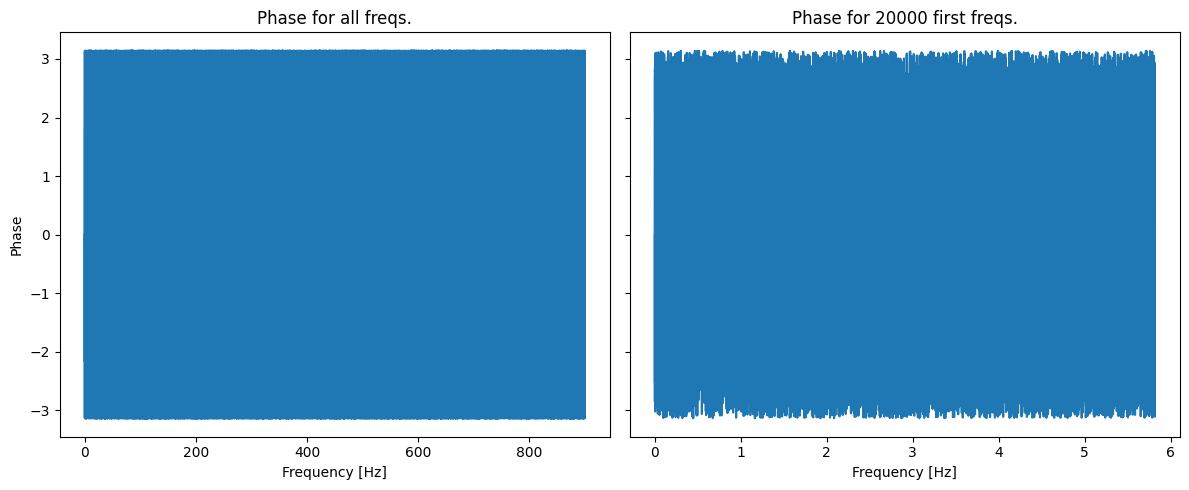

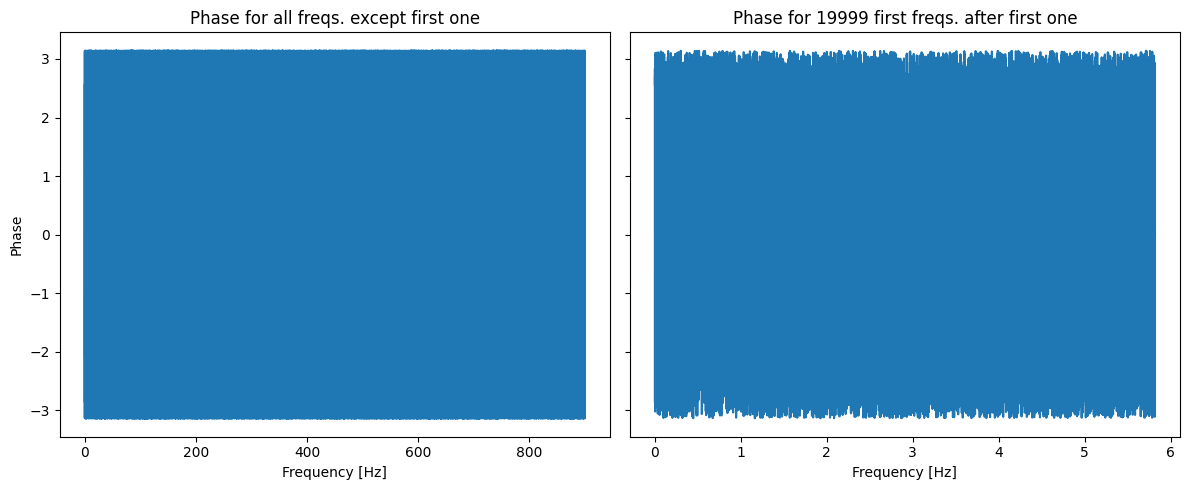

In [22]:
n = 20000  # number of frequencies to show

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].plot(3600*freqs[:y.size//2+1], phase_non_negative_freq[:])
axs[0].set_xlabel("Frequency [Hz]")   # TODO change units ... per hour
axs[0].set_ylabel("Phase")
axs[0].set_title("Phase for all freqs.")

axs[1].plot(3600*freqs[:y.size//2+1][:n], phase_non_negative_freq[:n])
axs[1].set_xlabel("Frequency [Hz]")  # TODO: fix the units ... per hour
axs[1].set_title(f"Phase for {n} first freqs.")
plt.tight_layout()
plt.show()


fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs2[0].plot(3600*freqs[1:y.size//2+1], phase_non_negative_freq[1:])
axs2[0].set_xlabel("Frequency [Hz]")   # TODO change units ... per hour
axs2[0].set_ylabel("Phase")
axs2[0].set_title("Phase for all freqs. except first one")

axs2[1].plot(3600*freqs[1:np.minimum(y.size//2+1, n)], phase_non_negative_freq[1:n])
axs2[1].set_xlabel("Frequency [Hz]")  # TODO: fix the units ... per hour
axs2[1].set_title(f"Phase for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()

Not very interpretable

And for even smaller subsets

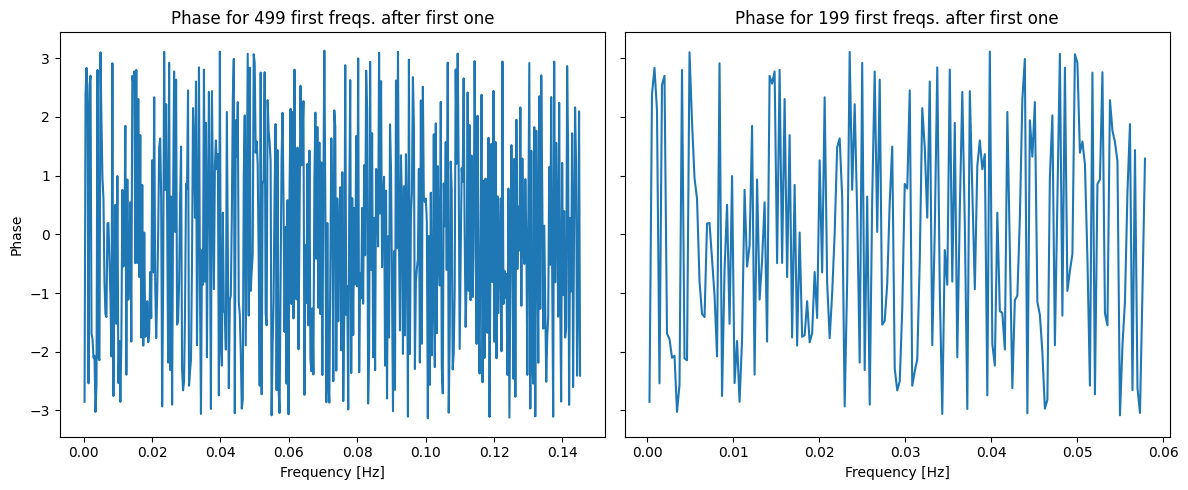

In [23]:
n = 500  # number of frequencies to show

fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs2[0].plot(3600*freqs[1:np.minimum(y.size//2+1, n)], phase_non_negative_freq[1:n])
axs2[0].set_xlabel("Frequency [Hz]")  # TODO: fix the units ... per hour
axs2[0].set_ylabel("Phase")
axs2[0].set_title(f"Phase for {n-1} first freqs. after first one")

n = 200  # number of frequencies to show

axs2[1].plot(3600*freqs[1:np.minimum(y.size//2+1, n)], phase_non_negative_freq[1:n])
axs2[1].set_xlabel("Frequency [Hz]")  # TODO: fix the units ... per hour
axs2[1].set_title(f"Phase for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()

Placing a line at the mean:

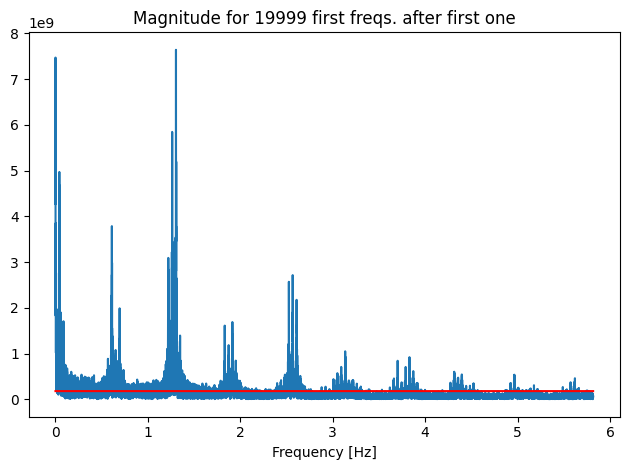

In [35]:
n = 20000  # number of frequencies to show

plt.plot(3600*freqs[1:np.minimum(y.size//2+1, n)], mag_non_negative_freq[1:n])
plt.plot(3600*freqs[1:np.minimum(y.size//2+1, n)],
         np.mean(mag_non_negative_freq[:n])*np.ones(n-1), 'r')
plt.xlabel("Frequency [Hz]")  # TODO: fix the units ... per hour
plt.title(f"Magnitude for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()

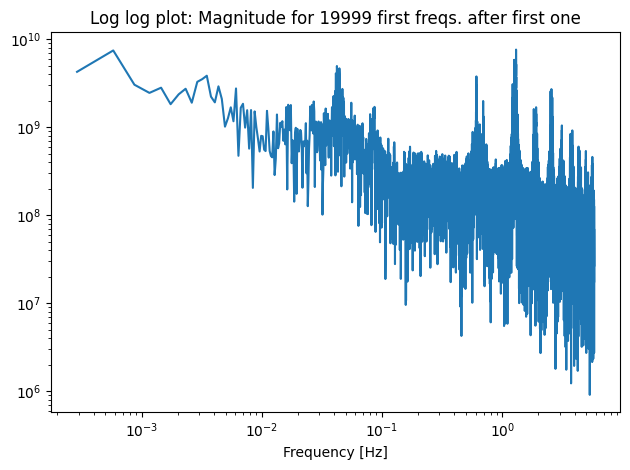

In [37]:
n = 20000  # number of frequencies to show

plt.loglog(3600*freqs[1:np.minimum(y.size//2+1, n)], mag_non_negative_freq[1:n])
plt.xlabel("Frequency [Hz]")  # TODO: fix the units ... per hour
plt.title(f"Log log plot: Magnitude for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()

Let's try to fit a power law and use it to apply local means on specific regions

In [40]:
x_tmp = np.log(3600*freqs[1:np.minimum(y.size//2+1, n)])
y_tmp = np.log(mag_non_negative_freq[1:n])

In [45]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x_tmp, y_tmp)
print(slope, intercept, r_value, p_value, std_err)

-0.4561899633444006 18.844238293990262 -0.4911029956949334 0.0 0.0057221532920807075


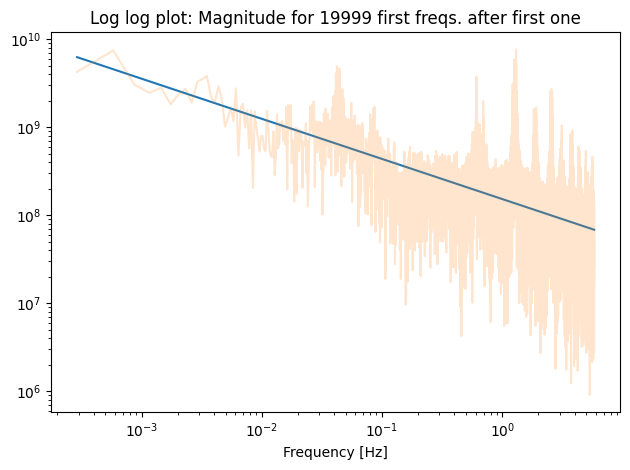

In [48]:
n = 20000  # number of frequencies to show

plt.plot(3600*freqs[1:np.minimum(y.size//2+1, n)],
         np.exp(slope*np.log(3600*freqs[1:np.minimum(y.size//2+1, n)]) + intercept),
         label="Linear regression 'using log'")

plt.loglog(3600*freqs[1:np.minimum(y.size//2+1, n)], mag_non_negative_freq[1:n],
          alpha=0.2)

plt.xlabel("Frequency [Hz]")  # TODO: fix the units ... per hour
plt.title(f"Log log plot: Magnitude for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()

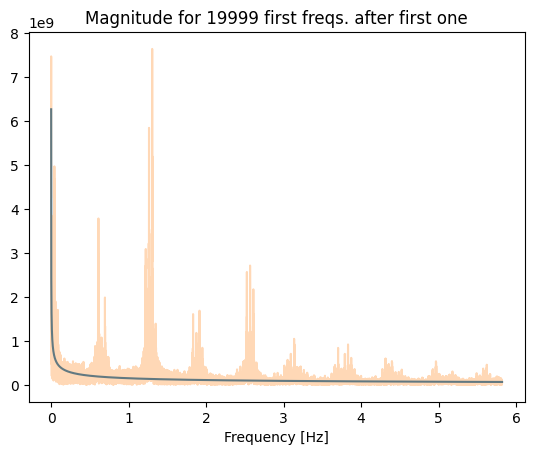

In [50]:
n = 20000  # number of frequencies to show

plt.plot(3600*freqs[1:np.minimum(y.size//2+1, n)],
         np.exp(slope*np.log(3600*freqs[1:np.minimum(y.size//2+1, n)]) + intercept),
         label="Linear regression 'using log'")

plt.plot(3600*freqs[1:np.minimum(y.size//2+1, n)], mag_non_negative_freq[1:n], alpha=0.3)

plt.xlabel("Frequency [Hz]")  # TODO: fix the units ... per hour
plt.title(f"Magnitude for {n-1} first freqs. after first one")
plt.show()

In [24]:
fft_res.size

6187623

In [25]:
t.size

6187623

In [26]:
1/(2*3600)*1e5

13.88888888888889

## Convolution with box filter in Fourier domain

- Over the whole Fourier domain

In [26]:
window_size = 100
mag_convolved = np.convolve(mag, np.ones(window_size)/window_size, "same")

mag_convolved_non_negative_freq = mag_convolved[:y.size//2+1]
# TODO: only do it for the big spikes and try with different window lengths
# TODO: be careful about padding !!

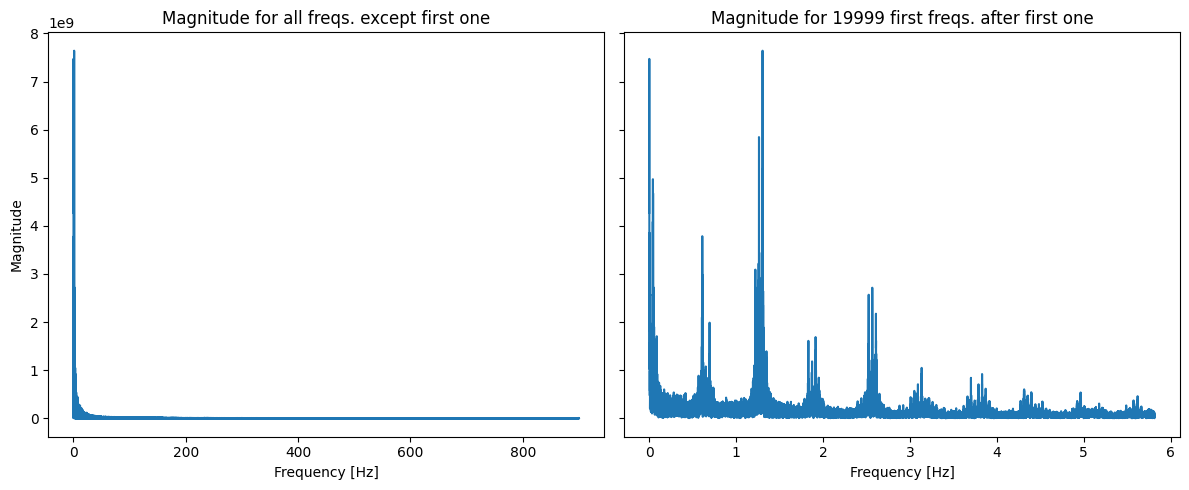

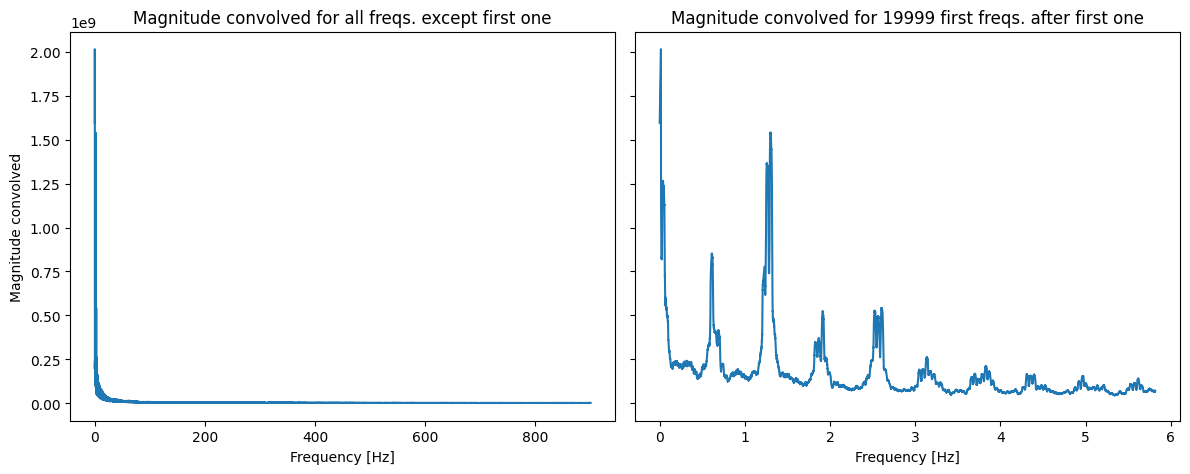

In [27]:
n = 20000  # number of frequencies to show

fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs2[0].plot(3600*freqs[1:y.size//2+1], mag_non_negative_freq[1:])
axs2[0].set_xlabel("Frequency [Hz]")   # TODO change units ... per hour
axs2[0].set_ylabel("Magnitude")
axs2[0].set_title("Magnitude for all freqs. except first one")

axs2[1].plot(3600*freqs[1:np.minimum(y.size//2+1, n)], mag_non_negative_freq[1:n])
axs2[1].set_xlabel("Frequency [Hz]")  # TODO: fix the units ... per hour
axs2[1].set_title(f"Magnitude for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()


fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs2[0].plot(3600*freqs[1:y.size//2+1], mag_convolved_non_negative_freq[1:])
axs2[0].set_xlabel("Frequency [Hz]")   # TODO change units ... per hour
axs2[0].set_ylabel("Magnitude convolved")
axs2[0].set_title("Magnitude convolved for all freqs. except first one")

axs2[1].plot(3600*freqs[1:np.minimum(y.size//2+1, n)], mag_convolved_non_negative_freq[1:n])
axs2[1].set_xlabel("Frequency [Hz]")  # TODO: fix the units ... per hour
axs2[1].set_title(f"Magnitude convolved for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()


In [28]:
t.shape, mag.shape

((6187623,), (6187623,))

In [29]:
reconstructed = np.fft.ifft(fft_res)

In [30]:
t.shape, reconstructed.shape, mag.shape, mag_convolved.shape, fft_res.shape

((6187623,), (6187623,), (6187623,), (6187623,), (6187623,))

In [31]:
reconstructed = np.fft.ifft(mag_convolved*np.exp(1j*np.angle(fft_res)))

In [32]:
reconstructed.shape

(6187623,)

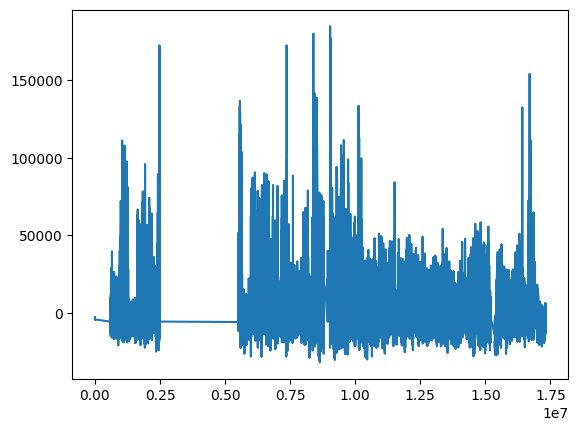

In [33]:
plt.plot(t, np.real(reconstructed))
plt.show()

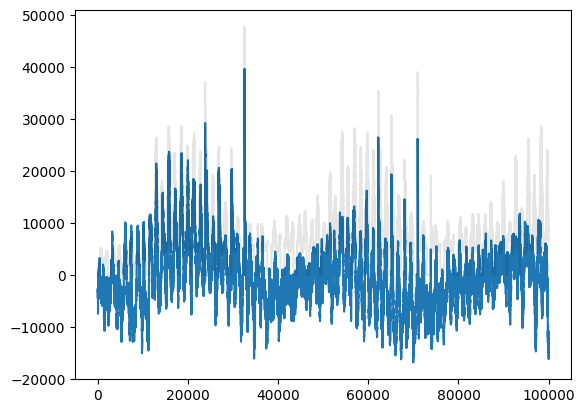

In [34]:
plt.plot(np.real(reconstructed)[:100000])
plt.plot(y[:100000], 'k', alpha=0.1)

In [35]:
fft_res.shape

(6187623,)

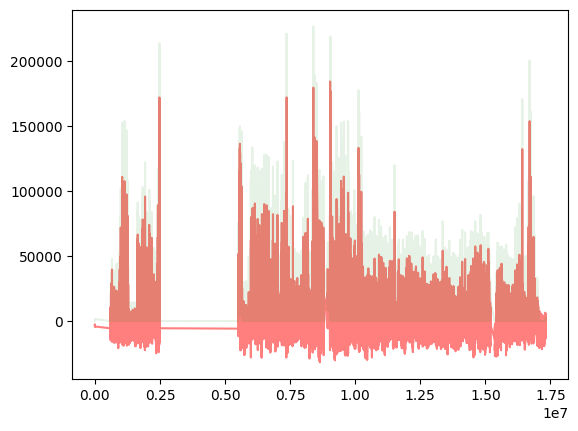

In [36]:
plt.plot(t, np.real(reconstructed), 'r', alpha=0.5)
plt.plot(t, y, 'g', alpha=0.1)

Values below zero doesn't make any sense physically (counts)

In [37]:
reconstructed.size

6187623

In [38]:
y.size

6187623

In [39]:
print(t.min(), t.max())  # TODO: need to take this into account 

2.0 17323036.0
